In [1]:
import os, sys, re, gc, glob

# set working dir
WORKING_DIR = re.sub('jdi-qasp-ml.*$','',os.path.normpath(os.getcwd())) + 'jdi-qasp-ml'
os.chdir(WORKING_DIR)

import torch
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm, trange
from sklearn.metrics import confusion_matrix
import json

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline

from tqdm.auto import tqdm, trange
from utils import JDNDataset, JDIModel, get_grey_image, assign_labels, logger, maximize_window, DatasetBuilder, load_gray_image
from time import sleep
from flask import jsonify

import datetime as dt
import requests

START_DT = dt.datetime.now()

2021-08-06 11:45:12,364 -INFO - config:config.py:25 - Module utils.config was loaded
2021-08-06 11:45:12,367 -INFO - common:common.py:618 - Module utils.common is loaded...
2021-08-06 11:45:12,368 -INFO - hidden:hidden.py:121 - hidden module is loaded
2021-08-06 11:45:12,374 -INFO - features_builder:features_builder.py:305 - feature_bilder module is loaded...
2021-08-06 11:45:12,377 -INFO - dataset_builder:dataset_builder.py:212 - dataset package is loaded...
2021-08-06 11:45:12,380 -INFO - dataset:dataset.py:277 - dataset module is loaded...


In [17]:
from IPython.display import display, HTML, clear_output

SITE_URL = 'https://yandex.ru/'
DATASET_NAME = 'yandex-ru'

SAVE_SCREEN = True
WAIT_TIME_SECONDS = 7
HEADLESS = True #False

PREDICT_URL = 'http://localhost:5000/predict'

display(HTML(f"<h1><i>Dataset name</i>: <u>{DATASET_NAME}</u></h1>"))

### getting json

2021-08-06 11:55:06,643 -INFO - dataset_builder:dataset_builder.py:78 - Dataset name: yandex-ru
2021-08-06 11:55:06,644 -INFO - dataset_builder:dataset_builder.py:87 - Create directories to save the dataset
2021-08-06 11:55:06,645 -INFO - dataset_builder:dataset_builder.py:125 - Creating driver
2021-08-06 11:55:07,839 -INFO - dataset_builder:dataset_builder.py:136 - Chrome web driver is created
2021-08-06 11:55:07,952 -INFO - <ipython-input-18-838104a0f931>:<ipython-input-18-838104a0f931>:10 - getting url: https://yandex.ru/
2021-08-06 11:55:12,119 -INFO - common:common.py:75 - Window maximized
2021-08-06 11:55:12,120 -INFO - dataset_builder:dataset_builder.py:139 - save scrinshot: dataset/images/yandex-ru.png
2021-08-06 11:55:14,206 -INFO - dataset_builder:dataset_builder.py:183 - Collect features using JS script
2021-08-06 11:55:18,428 -INFO - dataset_builder:dataset_builder.py:191 - Save html to dataset/html/yandex-ru.html
2021-08-06 11:55:18,601 -INFO - dataset_builder:dataset_buil

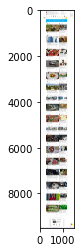

In [18]:
class DSBuilder(DatasetBuilder):
    def setUp(self, driver):
        """
            This method may be overwitten if you need to login to the site
            and navigate to a specific url,
            otherwise it just returns 
        """
        
        driver.set_window_size(width=1500, height=9500)  # <================== height
        logger.info(f'getting url: {self.url}')
        self.driver.get(self.url)
        sleep(3.0)
        maximize_window(driver=driver, extend_pix=0)
        
with DSBuilder(url=SITE_URL, dataset_name=DATASET_NAME, headless=True) as builder:
    plt.imshow(plt.imread(f'dataset/images/{DATASET_NAME}.png'))
    login_df = builder.dataset
    login_json = builder.dataset_json

  

In [19]:
PREDICT_URL

'http://localhost:5000/predict'

### Predict: sending json to backend and getting predictions

In [20]:
%%time

response = requests.post(
    PREDICT_URL, data=json.dumps(login_json)
)

if response.status_code == 200:
    display(json.loads(response.text))
else:
    raise Exception(response.text)

[{'element_id': '4778308093401142119389577910',
  'x': 0.0,
  'y': 531.671875,
  'width': 1466.0,
  'height': 10017.0,
  'predicted_label': 'range',
  'predicted_probability': 0.7870101929,
  'sort_key': 14684922.0},
 {'element_id': '0898507870401142112231515813',
  'x': 0.0,
  'y': 531.671875,
  'width': 1466.0,
  'height': 9977.0,
  'predicted_label': 'range',
  'predicted_probability': 0.9721904993,
  'sort_key': 14626282.0},
 {'element_id': '1606082242401142105208500410',
  'x': 0.0,
  'y': 0.0,
  'width': 1466.0,
  'height': 9500.0,
  'predicted_label': 'link',
  'predicted_probability': 0.5622122288,
  'sort_key': 13927000.0},
 {'element_id': '1434904386401142118105777288',
  'x': 274.0,
  'y': 531.671875,
  'width': 918.0,
  'height': 9977.0,
  'predicted_label': 'range',
  'predicted_probability': 0.8606455326,
  'sort_key': 9158886.0},
 {'element_id': '2571615776401142113760352051',
  'x': 274.0,
  'y': 531.671875,
  'width': 918.0,
  'height': 9965.0,
  'predicted_label': 'ra

Wall time: 9.88 s


In [21]:
response

<Response [200]>

In [22]:
print('Elapsed time:', dt.datetime.now() - START_DT)

Elapsed time: 0:10:41.914651


In [23]:
df = pd.read_parquet(f'dataset/df/{DATASET_NAME}.parquet')[['element_id', 'tag_name']]
df.head()

,element_id,tag_name
0,2738543504401142100093744565,HTML
1,1110136919401142107316815430,HEAD
2,0391343446401142100992751904,META
3,2785834466401142102239612822,META
4,3976855407401142105493258015,TITLE


In [24]:
predictions_df = pd.DataFrame(json.loads(response.text)).merge(df, on='element_id')
predictions_df

,element_id,x,y,width,height,predicted_label,predicted_probability,sort_key,tag_name
0,4778308093401142119389577910,0.000000,531.671875,1466.000000,10017.000000,range,0.787010,1.468492e+07,DIV
1,0898507870401142112231515813,0.000000,531.671875,1466.000000,9977.000000,range,0.972190,1.462628e+07,DIV
2,1606082242401142105208500410,0.000000,0.000000,1466.000000,9500.000000,link,0.562212,1.392700e+07,BODY
3,1434904386401142118105777288,274.000000,531.671875,918.000000,9977.000000,range,0.860646,9.158886e+06,DIV
4,2571615776401142113760352051,274.000000,531.671875,918.000000,9965.000000,range,0.927822,9.147870e+06,DIV
...,...,...,...,...,...,...,...,...,...
444,0504397640401142116125256159,425.132050,225.928925,14.142151,14.142151,checkbox,0.754811,2.000004e+02,I
445,4193588461401142111595839093,315.803925,225.928925,14.142151,14.142151,checkbox,0.754811,2.000004e+02,I
446,6611445386401142113630111262,548.507080,225.928925,14.142090,14.142151,checkbox,0.754811,1.999996e+02,I
447,4774687033401142116777711222,0.000000,0.000000,0.000000,0.000000,checkbox,0.614640,0.000000e+00,DIV


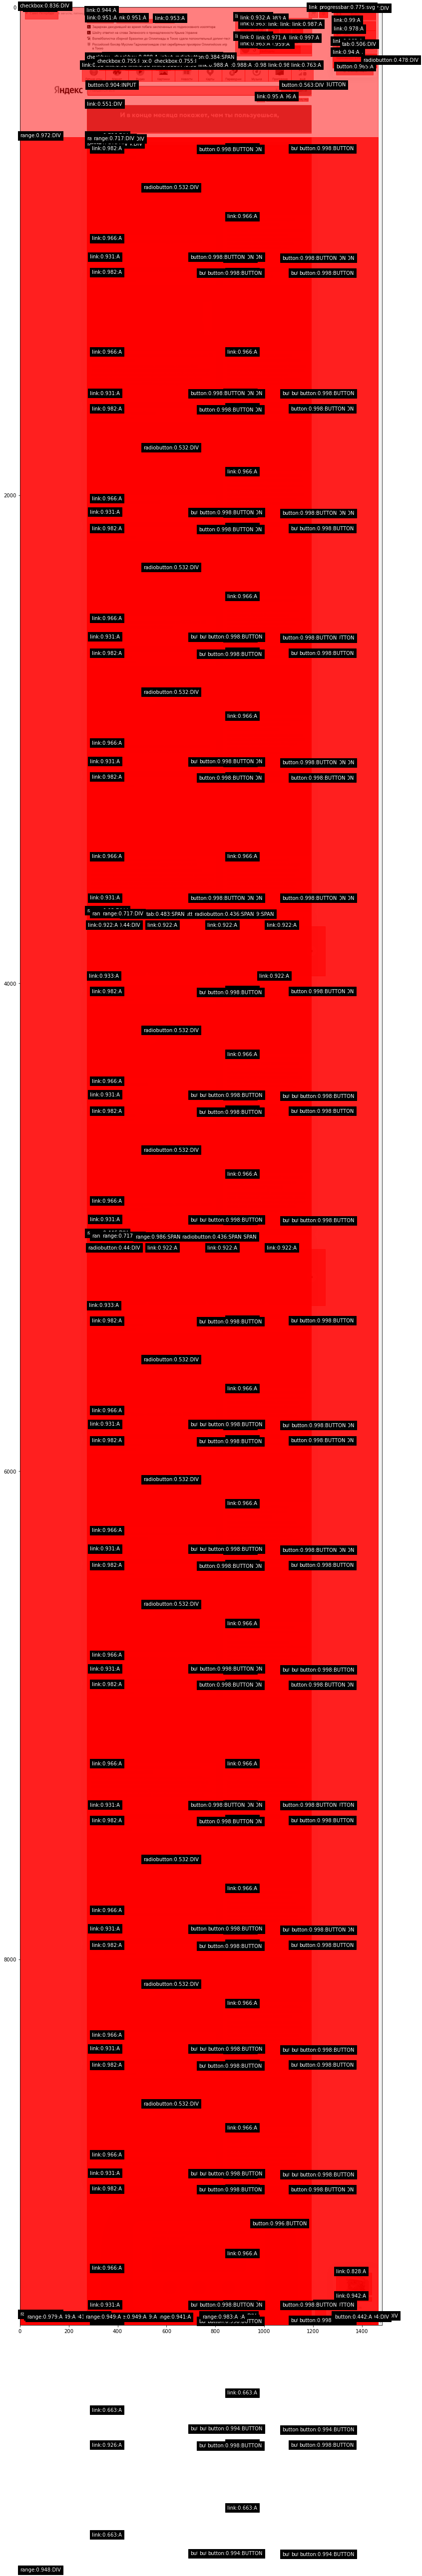

In [25]:
img = load_gray_image(f'dataset/images/{DATASET_NAME}.png')
plt.figure(figsize=(13,300))
plt.imshow(img, cmap='gray')

axes = plt.gca()

for _, r in predictions_df.iterrows():
    patch = Rectangle((r.x, r.y), r.width, r.height, alpha=.5, color='red')
    axes.add_patch(patch)
    
    axes.text(r.x, r.y, 
              r.predicted_label + ':' +str(round(r.predicted_probability, 3)) + ':' + r.tag_name, 
              backgroundcolor='black', 
              color='white')
    